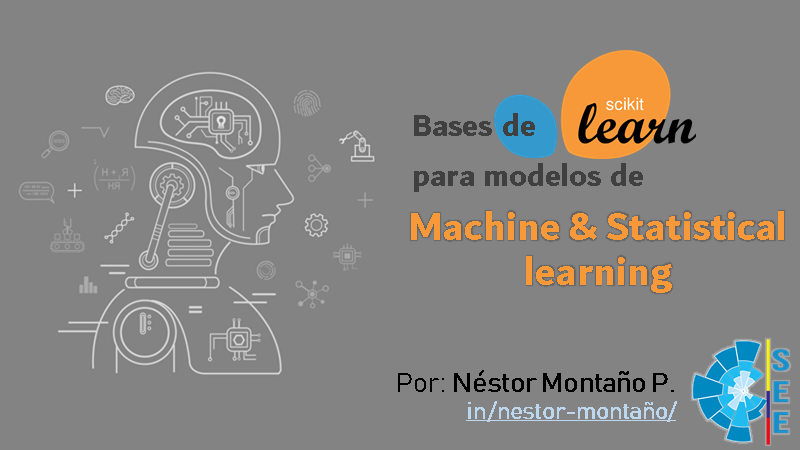

# Taller: Bases de Scikit-learn para modelos de Machine & Statistical learning

Taller dictado como parte del **Python Weekend 2021** de la Sociedad Ecuatoriana de Estadística, por Néstor Montaño.

Pueden encontrar el video de esta charla en  
www.facebook.com/socecuest

# Caso: Predecir el tiempo de demora de una transacción bancaria

El Banco SEE desea mejorar los tiempos de atención al cliente en ventanilla, la estrategia requiere predecir el tiempo en segundos que demora la atención para cada cliente.  

Se cuenta con datos recolectados anónimamente para cada cajero y transacción realizada, suministrados en un excel con tres hojas:  
- Hoja con los datos de las transacciones, columnas: Sucursal, Cajero, ID_Transaccion, Transaccion, Tiempo_Servicio_seg, Nivel de satisfacción, Monto de la transaccion.
- Hoja que indica si en la sucursal se ha puesto o no el nuevo sistema.
- Hoja con los datos de los cajeros: Edad, sexo, año de ingreso a la empresa.


## Preliminares

### Librerias

Cargar librerias básicas

In [ ]:
# Actualizar scikit-learn (esto porque Google Colab lo tiene desactualizado)
!pip install --upgrade scikit-learn

     |████████████████████████████████| 23.1 MB 1.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import sklearn
sklearn.__version__

'1.0'

In [ ]:
import os
import math as mt
import numpy as np
import pandas as pd 
import seaborn as sns


### Descargar datos

In [ ]:
#https://docs.google.com/spreadsheets/d/1VIcfQdi_YC56utN3uko43vPsvPXZqjNK/edit?usp=sharing&ouid=106537363253215222789&rtpof=true&sd=true
!gdown --id 1VIcfQdi_YC56utN3uko43vPsvPXZqjNK

Downloading...
From: https://drive.google.com/uc?id=1VIcfQdi_YC56utN3uko43vPsvPXZqjNK
To: /content/Data_Banco.xlsx
100% 881k/881k [00:00<00:00, 58.6MB/s]


### Importar Datos

Importar el excel descargado, cada una de las hojas

In [ ]:
# Importar el excel descargado, cada una de las hojas
data_banco_xlsx = pd.read_excel('Data_Banco.xlsx', sheet_name = 'Data')
data_banco_xlsx.head(5)

,Sucursal,Cajero,ID_Transaccion,Transaccion,Tiempo_Servicio_seg,Satisfaccion,Monto
0,62,4820,2,Cobro/Pago (Cta externa),622,Muy Bueno,"2889,3"
1,62,4820,2,Cobro/Pago (Cta externa),329,Malo,"1670,69"
2,62,4820,2,Cobro/Pago (Cta externa),643,Regular,"3172,49"
3,62,4820,2,Cobro/Pago (Cta externa),422,Regular,1764.92
4,62,4820,2,Cobro/Pago (Cta externa),378,Muy Bueno,1835.69


In [ ]:
data_sucursal = pd.read_excel('Data_Banco.xlsx', sheet_name = 'Data_Sucursal')
data_sucursal.head(5)

,ID_Sucursal,Sucursal,Nuevo_Sistema
0,62,Riocentro Sur,No
1,85,Centro,Si
2,267,Alborada,Si
3,443,Mall del Sol,Si
4,586,Via Daule,No


In [ ]:
data_cajero = pd.read_excel('Data_Banco.xlsx', sheet_name = 'Data_Cajero')
data_cajero.head(5)

,Cajero,Edad,Sexo,Nivel_Formacion,Anio Ingreso
0,4820,42,F,Bachiller,1995
1,5174,34,M,Univ Incom.,2010
2,5211,23,F,Univ Incom.,2017
3,5286,25,M,Tecnologia,2012
4,70,29,F,Bachiller,2015


In [ ]:
# Ver la estructura del data.frame
data_banco_xlsx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24299 entries, 0 to 24298
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Sucursal             24299 non-null  int64 
 1   Cajero               24299 non-null  int64 
 2   ID_Transaccion       24299 non-null  int64 
 3   Transaccion          24299 non-null  object
 4   Tiempo_Servicio_seg  24299 non-null  int64 
 5   Satisfaccion         24299 non-null  object
 6   Monto                24299 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.3+ MB


In [ ]:
# Modificar la coma por punto en Monto
data_banco_xlsx['Monto']= data_banco_xlsx['Monto'].replace(',','.', regex=True)
data_banco_xlsx["Monto"] = pd.to_numeric(data_banco_xlsx.Monto, errors='coerce')
data_banco_xlsx['Monto'].head(4)

0    2889.30
1    1670.69
2    3172.49
3    1764.92
Name: Monto, dtype: float64

In [ ]:
# Modificar a String
data_banco_xlsx['Sucursal'] = data_banco_xlsx['Sucursal'].astype(str)
data_banco_xlsx['Cajero'] = data_banco_xlsx['Cajero'].astype(str)
data_banco_xlsx['ID_Transaccion'] = data_banco_xlsx['ID_Transaccion'].astype(str)

In [ ]:
## Dato Categorical 
data_banco_xlsx['Satisfaccion'] = pd.Categorical( 
    data_banco_xlsx['Satisfaccion'],
    categories= ['Muy Malo', 'Malo', 'Regular', 'Bueno', 'Muy Bueno'], 
    ordered=True)
data_banco_xlsx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24299 entries, 0 to 24298
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Sucursal             24299 non-null  object  
 1   Cajero               24299 non-null  object  
 2   ID_Transaccion       24299 non-null  object  
 3   Transaccion          24299 non-null  object  
 4   Tiempo_Servicio_seg  24299 non-null  int64   
 5   Satisfaccion         24299 non-null  category
 6   Monto                24299 non-null  float64 
dtypes: category(1), float64(1), int64(1), object(4)
memory usage: 1.1+ MB


In [ ]:
# Modificar a String
data_sucursal['ID_Sucursal'] = data_sucursal['ID_Sucursal'].astype(str)
data_sucursal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID_Sucursal    5 non-null      object
 1   Sucursal       5 non-null      object
 2   Nuevo_Sistema  5 non-null      object
dtypes: object(3)
memory usage: 248.0+ bytes


In [ ]:
# Modificar a numerico
data_cajero['Edad'] =  pd.to_numeric(data_cajero['Edad'], errors='coerce')
# Modificar a String
data_cajero['Cajero'] = data_cajero['Cajero'].astype(str)
# Cambiar nombre
data_cajero.rename(columns={'Anio Ingreso':'Anio_Ingreso'}, inplace=True)
data_cajero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Cajero           27 non-null     object
 1   Edad             27 non-null     int64 
 2   Sexo             27 non-null     object
 3   Nivel_Formacion  27 non-null     object
 4   Anio_Ingreso     27 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ KB


In [ ]:
data_banco_xlsx= pd.merge( data_banco_xlsx.rename(columns={'Sucursal':'ID_Sucursal'}), 
         data_sucursal, on='ID_Sucursal')
data_banco_xlsx= pd.merge( data_banco_xlsx, data_cajero, on='Cajero')
# Verificar
data_banco_xlsx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24299 entries, 0 to 24298
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID_Sucursal          24299 non-null  object  
 1   Cajero               24299 non-null  object  
 2   ID_Transaccion       24299 non-null  object  
 3   Transaccion          24299 non-null  object  
 4   Tiempo_Servicio_seg  24299 non-null  int64   
 5   Satisfaccion         24299 non-null  category
 6   Monto                24299 non-null  float64 
 7   Sucursal             24299 non-null  object  
 8   Nuevo_Sistema        24299 non-null  object  
 9   Edad                 24299 non-null  int64   
 10  Sexo                 24299 non-null  object  
 11  Nivel_Formacion      24299 non-null  object  
 12  Anio_Ingreso         24299 non-null  int64   
dtypes: category(1), float64(1), int64(3), object(8)
memory usage: 2.4+ MB


### EDA Exploratory Data Analysis

Realizaremos un par de gráficos para entender el problema y la relación entre variables con la variable de interés: Tiempo de Servicio

Primero realizamos un histograma  del Tiempo de servicio

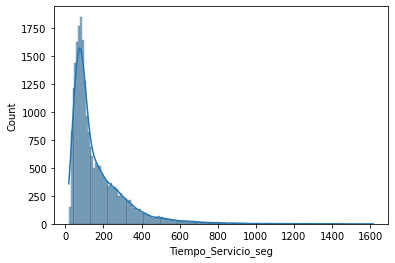

In [ ]:
sns.histplot(x=data_banco_xlsx['Tiempo_Servicio_seg'], kde=True)

¿Será que el tiempo se comporta diferente según cada transacción?

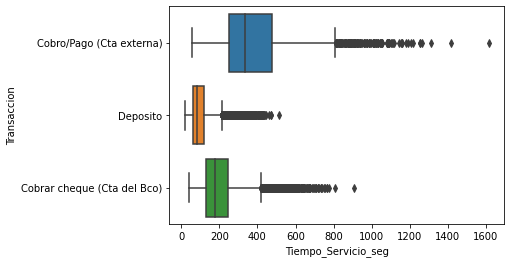

In [ ]:
sns.boxplot(x= "Tiempo_Servicio_seg", y= 'Transaccion', data= data_banco_xlsx)

¿Será que el tiempo se comporta diferente según si se tiene o no el Nuevo sistema en la sucursal?

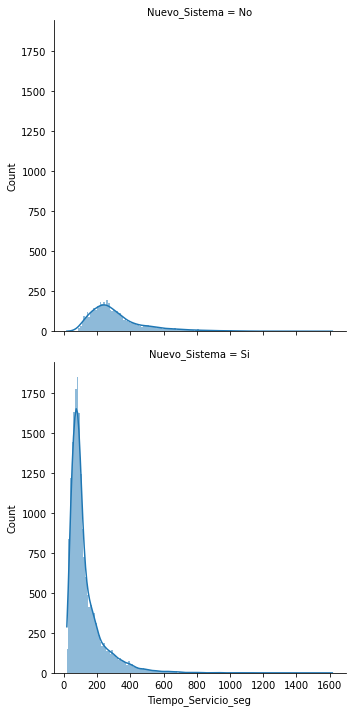

In [ ]:
sns.displot(x='Tiempo_Servicio_seg', row='Nuevo_Sistema', data= data_banco_xlsx, linewidth=0, kde=True);

¿Cómo se relacionan las variables numéricas?

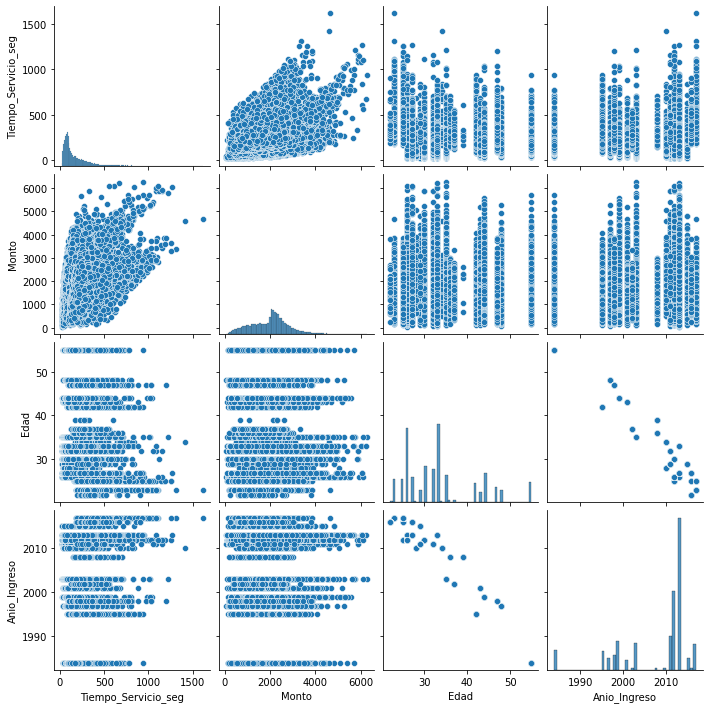

In [ ]:
sns.pairplot(data_banco_xlsx)

In [ ]:
cormat = data_banco_xlsx.corr()
round(cormat,2)

,Tiempo_Servicio_seg,Monto,Edad,Anio_Ingreso
Tiempo_Servicio_seg,1.00,0.41,-0.07,-0.01
Monto,0.41,1.00,0.01,0.00
Edad,-0.07,0.01,1.00,-0.93
Anio_Ingreso,-0.01,0.00,-0.93,1.00


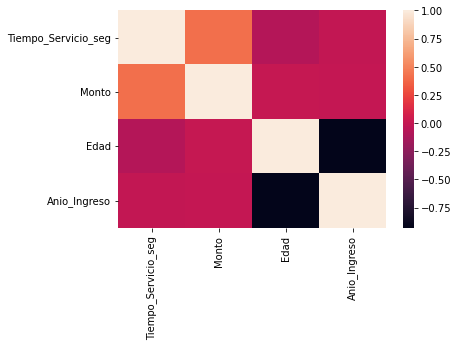

In [ ]:
sns.heatmap(cormat);

## Modelamiento con scikit-learn

In [ ]:
from sklearn import model_selection

### Train - test

Para tener una mejor representatividad de los valores del tiempo, se crean 10 estratos de tal manera que la partición train-test se realiza por estos:

In [ ]:
# Estratificación
data_banco_xlsx['Estrato'] = pd.qcut(data_banco_xlsx['Tiempo_Servicio_seg'], 10, labels=False)
data_banco_xlsx['Estrato']

0        9
1        8
2        9
3        9
4        9
        ..
24294    7
24295    7
24296    9
24297    8
24298    8
Name: Estrato, Length: 24299, dtype: int64

In [ ]:
train, test = model_selection.train_test_split(data_banco_xlsx, 
                                               test_size=0.2, random_state=123, 
                                               stratify= data_banco_xlsx['Estrato'])

In [ ]:
train

,ID_Sucursal,Cajero,ID_Transaccion,Transaccion,Tiempo_Servicio_seg,Satisfaccion,Monto,Sucursal,Nuevo_Sistema,Edad,Sexo,Nivel_Formacion,Anio_Ingreso,Estrato
20233,443,3732,3,Deposito,36,Muy Bueno,559.86,Mall del Sol,Si,27,M,Univ Incom.,2013,0
5034,85,357,10,Cobrar cheque (Cta del Bco),186,Bueno,2568.61,Centro,Si,32,F,Univ Incom.,2011,6
5805,85,472,3,Deposito,95,Muy Bueno,2010.32,Centro,Si,26,F,Tercer nivel,2013,4
20301,443,3732,3,Deposito,63,Malo,1314.14,Mall del Sol,Si,27,M,Univ Incom.,2013,1
20425,443,3732,3,Deposito,86,Bueno,2734.27,Mall del Sol,Si,27,M,Univ Incom.,2013,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20470,443,3732,3,Deposito,48,Bueno,2014.54,Mall del Sol,Si,27,M,Univ Incom.,2013,0
17743,267,4796,3,Deposito,91,Regular,2099.45,Alborada,Si,55,F,Bachiller,1984,3
18485,443,2958,3,Deposito,119,Bueno,2819.10,Mall del Sol,Si,26,F,Tercer nivel,2012,5
7922,85,472,10,Cobrar cheque (Cta del Bco),176,Muy Bueno,2380.76,Centro,Si,26,F,Tercer nivel,2013,6


In [ ]:
train.shape

(19439, 14)

In [ ]:
test.shape

(4860, 14)

In [ ]:
# Verificar estratos
train.groupby("Estrato")['Monto'].count()

Estrato
0    1979
1    1988
2    1990
3    1830
4    1992
5    1891
6    1950
7    1938
8    1954
9    1927
Name: Monto, dtype: int64

In [ ]:
test.groupby("Estrato")['Monto'].count()

Estrato
0    495
1    497
2    497
3    458
4    498
5    473
6    487
7    484
8    489
9    482
Name: Monto, dtype: int64

Otra opción es partir directamente el X y el Y en el train y el test, así:

In [ ]:
X_train, X_test, y_train, y_test= model_selection.train_test_split(
    data_banco_xlsx.drop('Tiempo_Servicio_seg', axis = 'columns'),
    data_banco_xlsx['Tiempo_Servicio_seg'],
    test_size=0.2, random_state=123, 
    stratify= data_banco_xlsx['Estrato'])

In [ ]:
X_train

,ID_Sucursal,Cajero,ID_Transaccion,Transaccion,Satisfaccion,Monto,Sucursal,Nuevo_Sistema,Edad,Sexo,Nivel_Formacion,Anio_Ingreso,Estrato
20233,443,3732,3,Deposito,Muy Bueno,559.86,Mall del Sol,Si,27,M,Univ Incom.,2013,0
5034,85,357,10,Cobrar cheque (Cta del Bco),Bueno,2568.61,Centro,Si,32,F,Univ Incom.,2011,6
5805,85,472,3,Deposito,Muy Bueno,2010.32,Centro,Si,26,F,Tercer nivel,2013,4
20301,443,3732,3,Deposito,Malo,1314.14,Mall del Sol,Si,27,M,Univ Incom.,2013,1
20425,443,3732,3,Deposito,Bueno,2734.27,Mall del Sol,Si,27,M,Univ Incom.,2013,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20470,443,3732,3,Deposito,Bueno,2014.54,Mall del Sol,Si,27,M,Univ Incom.,2013,0
17743,267,4796,3,Deposito,Regular,2099.45,Alborada,Si,55,F,Bachiller,1984,3
18485,443,2958,3,Deposito,Bueno,2819.10,Mall del Sol,Si,26,F,Tercer nivel,2012,5
7922,85,472,10,Cobrar cheque (Cta del Bco),Muy Bueno,2380.76,Centro,Si,26,F,Tercer nivel,2013,6


### Preprocesamiento

#### Preprocesamiento: Entendiendo los transformers y pipelines en scikit-learn

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [ ]:
prueba= pd.DataFrame({    
    'num1': [1, 6, 2, 4],
    'num2': [1, 2, np.nan, 3]})
prueba

,num1,num2
0,1,1.0
1,6,2.0
2,2,NaN
3,4,3.0


In [ ]:
StandardScaler().fit_transform(prueba)

array([[-1.1717002 , -1.22474487],
       [ 1.43207802,  0.        ],
       [-0.65094455,         nan],
       [ 0.39056673,  1.22474487]])

In [ ]:
SimpleImputer(strategy='mean').fit_transform(prueba)

array([[1., 1.],
       [6., 2.],
       [2., 2.],
       [4., 3.]])

In [ ]:
# PolynomialFeatures(include_bias= False).fit_transform(prueba) # <-- esto dará error porque hay NaN en los datos

Es necesario primero imputar y luego crear las interacciones, para ello usamos **pipelines** que es una utilidad de scikit-learn que permite aplicar las transformaciones una tras otra, como si fuesen una serie de pasos. En nuestro caso, paso 1 sería imputar, paso 2 crear las interacciones

In [ ]:
Pipeline_Numeric = Pipeline( steps=[    
    ('imputer', SimpleImputer(strategy='mean')),
    ('interacc', PolynomialFeatures(include_bias= False))
])

In [ ]:
# El resultado será:
# num1 | num2(imputado) | num1^2 |	num1*num2 | num2^2
Pipeline_Numeric.fit_transform(prueba)

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 6.,  2., 36., 12.,  4.],
       [ 2.,  2.,  4.,  4.,  4.],
       [ 4.,  3., 16., 12.,  9.]])

In [ ]:
prueba= pd.DataFrame({
    'cat1': ['a', 'a', 'b', 'b'],
    'cat2': ['x', 'y', 'x', 'y']})


Veamos una de las transformaciones disponibles para variables categóricas

In [ ]:
OneHotEncoder(sparse= False).fit_transform(prueba)

array([[1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.]])

Ahora **variables numéricas y categóricas**, en este caso usamos ColumnTransformer que nos permite aplicar funciones a columnas en paralelo (no una detrás de otra como en los pipelines)

In [ ]:
prueba= pd.DataFrame({
    'num1': [1, 6, 2, 4],
    'num2': [1, 2, np.nan, 3],
    'cat1': ['a', 'a', 'b', 'b'],
    'cat2': ['x', 'y', 'x', 'y']})
num_vars= ['num1', 'num2']
cat_vars= ['cat1', 'cat2']

In [ ]:
Preprocesam = ColumnTransformer(
                        transformers=[
                                      ('num', Pipeline_Numeric, num_vars),
                                      ('cat', OneHotEncoder(sparse= False), cat_vars),
                                      ],
                                remainder='drop'
                                )


In [ ]:
Preprocesam.fit_transform(prueba)

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.],
       [ 6.,  2., 36., 12.,  4.,  1.,  0.,  0.,  1.],
       [ 2.,  2.,  4.,  4.,  4.,  0.,  1.,  1.,  0.],
       [ 4.,  3., 16., 12.,  9.,  0.,  1.,  0.,  1.]])

In [ ]:
from sklearn import set_config
set_config(display='diagram')
Preprocesam

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('interacc',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['num1', 'num2']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['cat1', 'cat2'])])

In [ ]:
from sklearn import set_config
set_config(display='text')
Preprocesam

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('interacc',
                                                  PolynomialFeatures(include_bias=False))]),
                                 ['num1', 'num2']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['cat1', 'cat2'])])

notar que el resultado es una matriz, perdemos los nombres de columnas, investigar sobre get_feature_names()

#### Preprocesamiento: Aplicar al ejercicio

Notar que si queremos agregar interacciones (usar polinomial) debemos elegir las columnas que se requiera, esto puede implicar realizar un pipelines previo inclusive.

In [ ]:
Pipeline_Numeric = Pipeline( steps=[    
    ('imputer', SimpleImputer(strategy='mean')),
    ('interacc', StandardScaler())
])

In [ ]:
# Empezamos selecionando las variables que vamos a usar
num_vars= ['Monto', 'Edad', 'Anio_Ingreso']
cat_vars= ['Transaccion', 'Nuevo_Sistema' ]
# Si se quisieran todas, podríamos hacer:
# todas_categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
# todas_numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()


In [ ]:
Preprocesam = ColumnTransformer(
                        transformers=[
                                      ('num', Pipeline_Numeric, num_vars),
                                      ('cat', OneHotEncoder(sparse= False), cat_vars),
                                      ],
                                remainder='drop'
                                )

In [ ]:
X_train_prep = Preprocesam.fit_transform(X_train)

In [ ]:
X_train_prep

array([[-1.75450461, -0.77743416,  0.60120124, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.70068323, -0.17192004,  0.35494664, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.01831518, -0.89853699,  0.60120124, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.00684378, -0.89853699,  0.47807394, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.47108421, -0.89853699,  0.60120124, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.04882122, -0.89853699,  0.60120124, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
X_train_prep.shape

(19439, 8)

###  Modelamiento: Scikit learn


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.neighbors import KNeighborsRegressor

Definimos la estrategia de remuestreo

In [ ]:
# Estrategia de remuestreo
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)

Del módulo de vecinos cercanos, usaremos KNN para regresión.
https://scikit-learn.org/stable/modules/neighbors.html

In [ ]:
# Definir modelo
model_knn = KNeighborsRegressor()

In [ ]:
# Malla de hiperparámetros
grid = dict()
grid['n_neighbors'] = [7, 11, 21]
grid['weights'] = ['uniform', 'distance']

In [ ]:
grid

{'n_neighbors': [7, 11, 21], 'weights': ['uniform', 'distance']}

In [ ]:
# Remuestreo y afinamiento
tuned_knn = GridSearchCV(model_knn, grid, scoring= 'neg_mean_squared_error', cv=cv, n_jobs=-1)
# Pueden ver las metricas para scoring disponibles en https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [ ]:
tuned_knn.fit(X_train_prep, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=10, random_state=123),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [7, 11, 21],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [ ]:
# tuned_knn.cv_results_

Con `best_params_` podemos ver qué valores eligió para los hiperparámetros

In [ ]:
tuned_knn.best_params_

{'n_neighbors': 11, 'weights': 'uniform'}

Con `best_estimator_` seleccionamos el mejor modelo

In [ ]:
tuned_knn.best_estimator_

KNeighborsRegressor(n_neighbors=11)

In [ ]:
tuned_knn.best_estimator_.score(X_train_prep, y_train)

0.9596605545004014

### Evaluar Modelo

Para evaluar el modelo debemos primero preprocesar el test, notar que ya no se usa el `fit_transform` sino el `transform`. Luego se aplica el modelo (se predice) a los datos de prueba y comparamos estos resultados con los valores que debió dar realmente usando la métrica que prefiramos.


In [ ]:
X_test_prep  = Preprocesam.transform(X_test)

In [ ]:
y_test_pred = tuned_knn.predict(X_test_prep)
y_test_pred

array([ 42.36363636, 163.90909091, 303.63636364, ...,  28.90909091,
       132.36363636, 334.81818182])

In [ ]:
# RMSE
np.round(np.sqrt(mean_squared_error(y_test, y_test_pred )), 2)

31.18

In [ ]:
# MAE
np.round(mean_absolute_error(y_test, y_test_pred ), 2)

20.39

In [ ]:
# R_cuadrado
r2_score(y_test, y_test_pred )

0.9544060745105812